In [2]:
! pip install pyspark py4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=73ab7c0ea2f74f1b6bb419f5927df5f61cbce9959f7597751bc3639bbf1911ae
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
spark = SparkSession.builder.appName("firstapp").getOrCreate()

**week5.task1:what is the ratio of payment using cc or app wallet**

In [4]:
df = spark.read.csv('/content/drive/MyDrive/Data_Raw_FordGoBike', header = True, inferSchema = True)
df.show(3)

+------------+--------------------+--------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+---------+-----------------+-------------+-----------+
|duration_sec|          start_time|            end_time|start_station_id|  start_station_name|start_station_latitude|start_station_longitude|end_station_id|    end_station_name|end_station_latitude|end_station_longitude|bike_id|user_type|member_birth_year|member_gender|     pyment|
+------------+--------------------+--------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+---------+-----------------+-------------+-----------+
|       80110|2017-12-31 16:57:...|2018-01-01 15:12:...|              74|Laguna St at Haye...|    37.776434819204745|    -122.42624402046204|          

In [5]:
df11 = df.withColumn('CC', F.when(F.col('pyment') == 'credit card', 1).otherwise(0)).withColumn('App W', F.when(F.col('pyment') == 'app wallet', 1).otherwise(0))

df11.select('CC', 'App W','pyment').show(10)

+---+-----+-----------+
| CC|App W|     pyment|
+---+-----+-----------+
|  1|    0|credit card|
|  1|    0|credit card|
|  1|    0|credit card|
|  1|    0|credit card|
|  0|    1| app wallet|
|  0|    1| app wallet|
|  0|    1| app wallet|
|  0|    1| app wallet|
|  0|    1| app wallet|
|  0|    1| app wallet|
+---+-----+-----------+
only showing top 10 rows



In [6]:
from pyspark.sql.functions import desc
df4 = df11.agg({'pyment':'count', 'CC':'sum', 'App W': 'sum'}).orderBy(desc('count(pyment)')).limit(10)
df5 = df4.withColumn('CC_ratio', df4[0]/df4[2])
df6 = df5.withColumn('App W_ratio', df4[1]/df4[2])
df6.show(10)

+-------+----------+-------------+-------------------+------------------+
|sum(CC)|sum(App W)|count(pyment)|           CC_ratio|       App W_ratio|
+-------+----------+-------------+-------------------+------------------+
| 209644|    210056|       419700|0.49950917321896593|0.5004908267810341|
+-------+----------+-------------+-------------------+------------------+



**week5.task2:what is the preferred way to pay for customers and subscriber**

In [7]:
df4 = df11.groupby('user_type').agg({'CC': 'sum', 'App W': 'sum'}).limit(10)
df_per = df4.withColumn('%', (df4[1]/(df4[1]+df4[2])*100))
df_per.show()

+----------+-------+----------+-----------------+
| user_type|sum(CC)|sum(App W)|                %|
+----------+-------+----------+-----------------+
|Subscriber| 165555|    165831|  49.958356719958|
|  Customer|  44089|     44225|49.92300201553548|
+----------+-------+----------+-----------------+



**wee5.task3:Analyze the relationship between trip duration and user type (subscriber vs. customer) to understand differences in usage patterns.**


In [10]:
import pandas as pd
import seaborn as sns

df2=df.toPandas()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


<Axes: xlabel='duration_sec', ylabel='Density'>

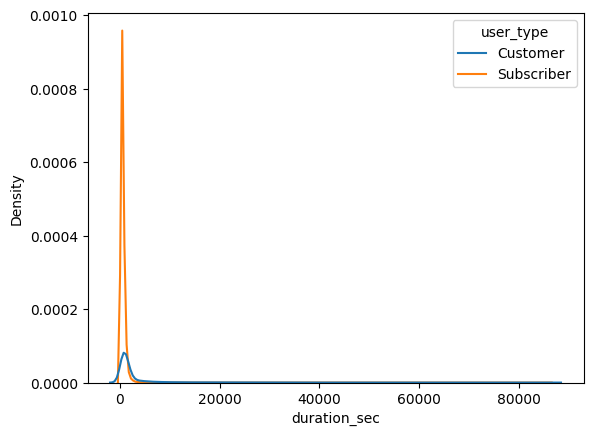

In [11]:
sns.kdeplot(data=df2, x="duration_sec", hue="user_type")

<Axes: xlabel='user_type', ylabel='duration_sec'>

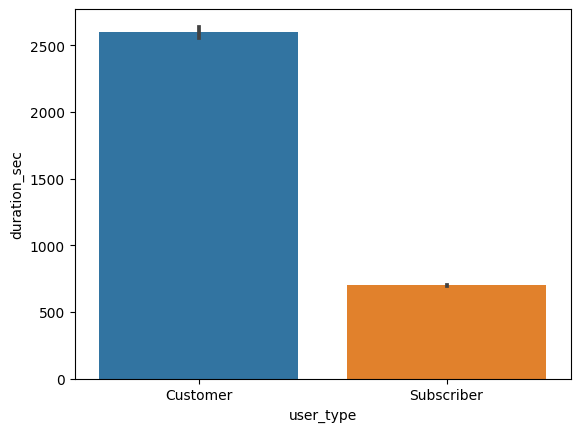

In [13]:
sns.barplot(x= df2["user_type"], y= df2['duration_sec'], data=df2)